# Assignment 4
## Title: Association Rules

Name: Pranjal Rane

NUID: 002756852

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
from IPython.display import clear_output
import pyfpgrowth

### Helper Functions for implementing the Apriori 

In [2]:
# (c) 2016 Everaldo Aguiar & Reid Johnson
#
# Modified from:
# Marcel Caraciolo (https://gist.github.com/marcelcaraciolo/1423287)
#
# Functions to compute and extract association rules from a given frequent itemset
# generated by the Apriori algorithm.
#
# The Apriori algorithm is defined by Agrawal and Srikant in:
# Fast algorithms for mining association rules
# Proc. 20th int. conf. very large data bases, VLDB. Vol. 1215. 1994

def load_dataset(filename):
    '''Loads an example of market basket transactions from a provided csv file.

    Returns: A list (database) of lists (transactions). Each element of a transaction is
    an item.
    '''

    with open(filename,'r') as dest_f:
        data_iter = csv.reader(dest_f, delimiter = ',', quotechar = '"')
        data = [data for data in data_iter]
        data_array = np.asarray(data, dtype=object)

    return data_array

def apriori(dataset, min_support=0.5, verbose=False):
    """Implements the Apriori algorithm.

    The Apriori algorithm will iteratively generate new candidate
    k-itemsets using the frequent (k-1)-itemsets found in the previous
    iteration.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate
        candidate itemsets.

    min_support : float
        The minimum support threshold. Defaults to 0.5.

    Returns
    -------
    F : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.

    References
    ----------
    .. [1] R. Agrawal, R. Srikant, "Fast Algorithms for Mining Association
           Rules", 1994.

    """
    C1 = create_candidates(dataset)
    D = list(map(set, dataset))
    F1, support_data = support_prune(D, C1, min_support, verbose=False) # prune candidate 1-itemsets
    F = [F1] # list of frequent itemsets; initialized to frequent 1-itemsets
    k = 2 # the itemset cardinality
    while (len(F[k - 2]) > 0):
        Ck = apriori_gen(F[k-2], k) # generate candidate itemsets
        Fk, supK = support_prune(D, Ck, min_support) # prune candidate itemsets
        support_data.update(supK) # update the support counts to reflect pruning
        F.append(Fk) # add the pruned candidate itemsets to the list of frequent itemsets
        k += 1

    if verbose:
        # Print a list of all the frequent itemsets.
        for kset in F:
            for item in kset:
                print("" \
                    + "{" \
                    + "".join(str(i) + ", " for i in iter(item)).rstrip(', ') \
                    + "}" \
                    + ":  sup = " + str(round(support_data[item], 3)))

    return F, support_data

def create_candidates(dataset, verbose=False):
    """Creates a list of candidate 1-itemsets from a list of transactions.

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate
        itemsets.

    Returns
    -------
    The list of candidate itemsets (c1) passed as a frozenset (a set that is
    immutable and hashable).
    """
    c1 = [] # list of all items in the database of transactions
    for transaction in dataset:
        for item in transaction:
            if not [item] in c1:
                c1.append([item])
    c1.sort()

    if verbose:
        # Print a list of all the candidate items.
        print("" \
            + "{" \
            + "".join(str(i[0]) + ", " for i in iter(c1)).rstrip(', ') \
            + "}")

    # Map c1 to a frozenset because it will be the key of a dictionary.
    return list(map(frozenset, c1))

def support_prune(dataset, candidates, min_support, verbose=False):
    """Returns all candidate itemsets that meet a minimum support threshold.

    By the apriori principle, if an itemset is frequent, then all of its
    subsets must also be frequent. As a result, we can perform support-based
    pruning to systematically control the exponential growth of candidate
    itemsets. Thus, itemsets that do not meet the minimum support level are
    pruned from the input list of itemsets (dataset).

    Parameters
    ----------
    dataset : list
        The dataset (a list of transactions) from which to generate candidate
        itemsets.

    candidates : frozenset
        The list of candidate itemsets.

    min_support : float
        The minimum support threshold.

    Returns
    -------
    retlist : list
        The list of frequent itemsets.

    support_data : dict
        The support data for all candidate itemsets.
    """
    sscnt = {} # set for support counts
    for tid in dataset:
        for can in candidates:
            if can.issubset(tid):
                sscnt.setdefault(can, 0)
                sscnt[can] += 1

    num_items = float(len(dataset)) # total number of transactions in the dataset
    retlist = [] # array for unpruned itemsets
    support_data = {} # set for support data for corresponding itemsets
    for key in sscnt:
        # Calculate the support of itemset key.
        support = sscnt[key] / num_items
        if support >= min_support:
            retlist.insert(0, key)
        support_data[key] = support

    # Print a list of the pruned itemsets.
    if verbose:
        for kset in retlist:
            for item in kset:
                print("{" + str(item) + "}")
        print("")
        for key in sscnt:
            print("" \
                + "{" \
                + "".join([str(i) + ", " for i in iter(key)]).rstrip(', ') \
                + "}" \
                + ":  sup = " + str(support_data[key]))

    return retlist, support_data

def apriori_gen(freq_sets, k):
    """Generates candidate itemsets (via the F_k-1 x F_k-1 method).

    This operation generates new candidate k-itemsets based on the frequent
    (k-1)-itemsets found in the previous iteration. The candidate generation
    procedure merges a pair of frequent (k-1)-itemsets only if their first k-2
    items are identical.

    Parameters
    ----------
    freq_sets : list
        The list of frequent (k-1)-itemsets.

    k : integer
        The cardinality of the current itemsets being evaluated.

    Returns
    -------
    retlist : list
        The list of merged frequent itemsets.
    """
    retList = [] # list of merged frequent itemsets
    lenLk = len(freq_sets) # number of frequent itemsets
    for i in range(lenLk):
        for j in range(i+1, lenLk):
            a=list(freq_sets[i])
            b=list(freq_sets[j])
            a.sort()
            b.sort()
            F1 = a[:k-2] # first k-2 items of freq_sets[i]
            F2 = b[:k-2] # first k-2 items of freq_sets[j]

            if F1 == F2: # if the first k-2 items are identical
                # Merge the frequent itemsets.
                retList.append(freq_sets[i] | freq_sets[j])

    return retList

def rules_from_conseq(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Generates a set of candidate rules.

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    support_data : dict
        The support data for all candidate itemsets.

    rules : list
        A potentially incomplete set of candidate rules above the minimum
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.
    """
    m = len(H[0])
    if m == 1:
        Hmp1 = calc_confidence(freq_set, H, support_data, rules, min_confidence, verbose)
    if (len(freq_set) > (m+1)):
        Hmp1 = apriori_gen(H, m+1) # generate candidate itemsets
        Hmp1 = calc_confidence(freq_set, Hmp1, support_data, rules, min_confidence, verbose)
        if len(Hmp1) > 1:
            # If there are candidate rules above the minimum confidence
            # threshold, recurse on the list of these candidate rules.
            rules_from_conseq(freq_set, Hmp1, support_data, rules, min_confidence, verbose)

def calc_confidence(freq_set, H, support_data, rules, min_confidence=0.5, verbose=False):
    """Evaluates the generated rules.

    One measurement for quantifying the goodness of association rules is
    confidence. The confidence for a rule 'P implies H' (P -> H) is defined as
    the support for P and H divided by the support for P
    (support (P|H) / support(P)), where the | symbol denotes the set union
    (thus P|H means all the items in set P or in set H).

    To calculate the confidence, we iterate through the frequent itemsets and
    associated support data. For each frequent itemset, we divide the support
    of the itemset by the support of the antecedent (left-hand-side of the
    rule).

    Parameters
    ----------
    freq_set : frozenset
        The complete list of frequent itemsets.

    H : list
        A list of frequent itemsets (of a particular length).

    min_support : float
        The minimum support threshold.

    rules : list
        A potentially incomplete set of candidate rules above the minimum
        confidence threshold.

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    pruned_H : list
        The list of candidate rules above the minimum confidence threshold.
    """
    pruned_H = [] # list of candidate rules above the minimum confidence threshold
    for conseq in H: # iterate over the frequent itemsets
        conf = support_data[freq_set] / support_data[freq_set - conseq]
        if conf >= min_confidence:
            rules.append((freq_set - conseq, conseq, conf))
            pruned_H.append(conseq)

            if verbose:
                print("" \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(freq_set-conseq)]).rstrip(', ') \
                    + "}" \
                    + " ---> " \
                    + "{" \
                    + "".join([str(i) + ", " for i in iter(conseq)]).rstrip(', ') \
                    + "}" \
                    + ":  conf = " + str(round(conf, 3)) \
                    + ", sup = " + str(round(support_data[freq_set], 3)))

    return pruned_H

def generate_rules(F, support_data, min_confidence=0.5, verbose=True):
    """Generates a set of candidate rules from a list of frequent itemsets.

    For each frequent itemset, we calculate the confidence of using a
    particular item as the rule consequent (right-hand-side of the rule). By
    testing and merging the remaining rules, we recursively create a list of
    pruned rules.

    Parameters
    ----------
    F : list
        A list of frequent itemsets.

    support_data : dict
        The corresponding support data for the frequent itemsets (L).

    min_confidence : float
        The minimum confidence threshold. Defaults to 0.5.

    Returns
    -------
    rules : list
        The list of candidate rules above the minimum confidence threshold.
    """
    rules = []
    for i in range(1, len(F)):
        for freq_set in F[i]:
            H1 = [frozenset([itemset]) for itemset in freq_set]
            if (i > 1):
                rules_from_conseq(freq_set, H1, support_data, rules, min_confidence, verbose)
            else:
                calc_confidence(freq_set, H1, support_data, rules, min_confidence, verbose)

    return rules

### Part 1

Apriori

In [3]:
dataset = load_dataset('grocery.csv')
data_set_list = list(map(set, dataset))

#### Task 1

Make use of the provided functions to generate candidate itemsets,
select those that are frequent using Apriori, and subsequently list association rules
derived from these.

In [4]:
min_support_parameters = [0.005*i for i in range(1,30,3)]
min_confidence = 0.4

for min_support in min_support_parameters:
  frequent_itemsets, support_data = apriori(dataset, min_support)
  generated_rules = generate_rules(frequent_itemsets, support_data, min_confidence)
  print(f"\n ---------------- Minimum Support ---------------- {min_support} ----------------- \n")
  print(generated_rules)

{pot plants} ---> {whole milk}:  conf = 0.4, sup = 0.007
{chicken} ---> {whole milk}:  conf = 0.41, sup = 0.018
{pasta} ---> {whole milk}:  conf = 0.405, sup = 0.006
{onions} ---> {other vegetables}:  conf = 0.459, sup = 0.014
{semi-finished bread} ---> {whole milk}:  conf = 0.402, sup = 0.007
{herbs} ---> {whole milk}:  conf = 0.475, sup = 0.008
{herbs} ---> {other vegetables}:  conf = 0.475, sup = 0.008
{herbs} ---> {root vegetables}:  conf = 0.431, sup = 0.007
{mustard} ---> {whole milk}:  conf = 0.432, sup = 0.005
{sliced cheese} ---> {whole milk}:  conf = 0.44, sup = 0.011
{white bread} ---> {whole milk}:  conf = 0.406, sup = 0.017
{cake bar} ---> {whole milk}:  conf = 0.423, sup = 0.006
{baking powder} ---> {whole milk}:  conf = 0.523, sup = 0.009
{soft cheese} ---> {whole milk}:  conf = 0.44, sup = 0.008
{soft cheese} ---> {other vegetables}:  conf = 0.417, sup = 0.007
{hard cheese} ---> {whole milk}:  conf = 0.411, sup = 0.01
{cream cheese} ---> {whole milk}:  conf = 0.415, sup

#### Task 2

We can find a relationship between the confidence level and number of rules foundfor a certain support value. For this, plot the number of rules found on y-axis and confidencelevels on x-axis for different support values. Use 10%, 20%, 30%, 40%, 50% confidence levelsfor each of 2%, 3%, 4%, 5% support levels in the same figure. Plot a separate line for eachsupport level.

In [5]:
confidence_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
support_levels = [0.02, 0.03, 0.04, 0.05]

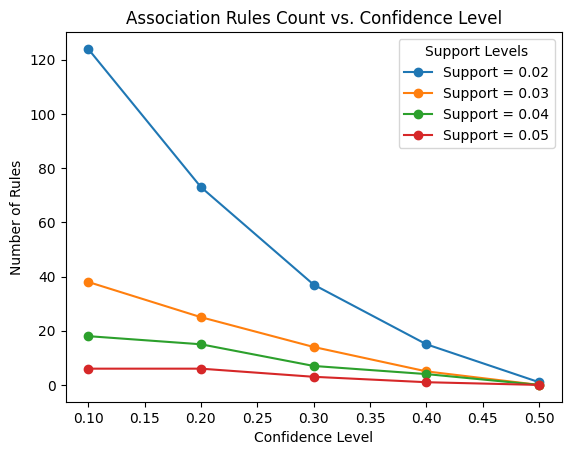

In [6]:
fig, ax = plt.subplots()

for support in support_levels:
    frequent_itemsets, support_info = apriori(dataset, min_support=support)
    
    counts_of_rules = []
    
    for confidence in confidence_levels:
        generated_rules = generate_rules(frequent_itemsets, support_info, min_confidence=confidence)
        counts_of_rules.append(len(generated_rules))
    
    clear_output(wait=True)
    
    ax.plot(confidence_levels, counts_of_rules, marker='o', label=f'Support = {support}')

ax.set_xlabel('Confidence Level')
ax.set_ylabel('Number of Rules')
ax.legend(title='Support Levels')
plt.title('Association Rules Count vs. Confidence Level')
plt.show()

### Part 2

FPgrowth

I am using the pyfpgrowth library. It contains Python implementation of FPgrowth algorithm implementation by Evan Dempsey

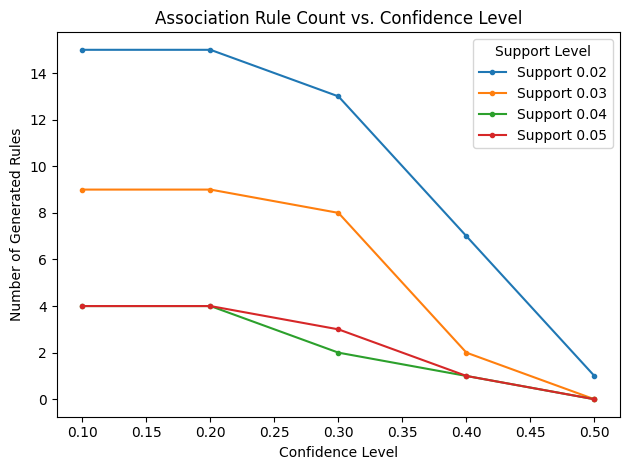

In [10]:
fig, plot_ax = plt.subplots()

for support in support_levels:
    abs_support = int(support * len(data_set_list))
    
    frequent_patterns = pyfpgrowth.find_frequent_patterns(data_set_list, abs_support)
    
    num_rules_at_confidence = []
    
    for confidence in confidence_levels:
        generated_rules = pyfpgrowth.generate_association_rules(frequent_patterns, confidence)
        num_rules_at_confidence.append(len(generated_rules))
    
    plot_ax.plot(confidence_levels, num_rules_at_confidence, marker='.', linestyle='-', label=f'Support {support}')

plot_ax.set_title('Association Rule Count vs. Confidence Level')
plot_ax.set_xlabel('Confidence Level')
plot_ax.set_ylabel('Number of Generated Rules')
plot_ax.legend(title='Support Level', loc='upper right')

plt.tight_layout()
plt.show()

### Part 3

Interest Factor

In [18]:
def calc_interest_factor(sup_a, sup_b, sup_ab):
    return sup_ab / (sup_a * sup_b)

def order_rules(all_rules, sup_data, top_n=None):
    by_support = sorted(all_rules, key=lambda r: -sup_data[r[0]])
    by_confidence = sorted(all_rules, key=lambda r: -r[2])
    by_interest = sorted(all_rules, key=lambda r: calc_interest_factor(sup_data[r[0]], sup_data[r[1]], sup_data[r[0] | r[1]]))
    
    if top_n:
        return by_support[:top_n], by_confidence[:top_n], by_interest[:top_n]
    else:
        return by_support, by_confidence, by_interest

def display_top_rules(sorted_rules, limit=5):
    for index, (ante, conse, conf) in enumerate(sorted_rules[:limit], 1):
        print(f"Rule {index}: {', '.join(str(item) for item in ante)} --> {', '.join(str(item) for item in conse)} with confidence {conf}")
    print(" ")

In [21]:
frequent_sets, supp_data = apriori(dataset, 0.02, False)
derived_rules = generate_rules(frequent_sets, supp_data, 0.3, False)

support_sorted, confidence_sorted, interest_sorted = order_rules(derived_rules, supp_data, 5)

print("Top 5 by Support:")
display_top_rules(support_sorted)

print("Top 5 by Confidence:")
display_top_rules(confidence_sorted)

print("Top 5 by Interest Factor:")
display_top_rules(interest_sorted)

common_support_confidence = set(support_sorted) & set(confidence_sorted)
common_support_interest = set(support_sorted) & set(interest_sorted)
common_confidence_interest = set(confidence_sorted) & set(interest_sorted)

if common_support_confidence:
    print("Shared between Support & Confidence:")
    display_top_rules(list(common_support_confidence), len(common_support_confidence))

print(" ")

if common_support_interest:
    print("Shared between Support & Interest Factor:")
    display_top_rules(list(common_support_interest), len(common_support_interest))

if common_confidence_interest:
    print("Shared between Confidence & Interest Factor:")
    display_top_rules(list(common_confidence_interest), len(common_confidence_interest))


Top 5 by Support:
Rule 1: other vegetables --> whole milk with confidence 0.38675775091960063
Rule 2: rolls/buns --> whole milk with confidence 0.30790491984521834
Rule 3: yogurt --> other vegetables with confidence 0.3112244897959184
Rule 4: yogurt --> whole milk with confidence 0.40160349854227406
Rule 5: bottled water --> whole milk with confidence 0.31094756209751606
 
Top 5 by Confidence:
Rule 1: yogurt, other vegetables --> whole milk with confidence 0.5128805620608898
Rule 2: butter --> whole milk with confidence 0.4972477064220184
Rule 3: curd --> whole milk with confidence 0.4904580152671756
Rule 4: other vegetables, root vegetables --> whole milk with confidence 0.4892703862660944
Rule 5: root vegetables, whole milk --> other vegetables with confidence 0.47401247401247404
 
Top 5 by Interest Factor:
Rule 1: rolls/buns --> whole milk with confidence 0.30790491984521834
Rule 2: bottled water --> whole milk with confidence 0.31094756209751606
Rule 3: sausage --> whole milk with 